In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display

In [3]:
from os.path import join, dirname, exists
from os import makedirs

from thesis_v2 import dir_dict
import pandas as pd


f_main_result = join(dir_dict['analyses'], 'gaya_refactored', '20200801', 'main_result.pkl')

In [4]:
df_main_result = pd.read_pickle(f_main_result)
assert df_main_result.index.is_unique

In [5]:
df_main_result

cc2_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                
relu     True                 mse       0          2         8           1           cm-avg       950            0.358683   
         False                mse       0          2         8           1           cm-avg       950            0.342887   
         True                 mse       0          2         8           2           cm-avg       950            0.384929   
         False                mse       0          2         8           2           cm-avg       950            0.382683   
         True                 mse       0          2         8           3           cm-avg       950            0.376820   
...                                                                                                                   ...   
softplus False                poisson   1          4         32          1           legacy       3800           0.498975   
         True                 poisson   1          5         32          1           legacy       3800           0.492938   
         False                poisson   1          5         32          1           legacy       3800           0.493143   
         True                 poisson   1          6         32          1           legacy       3800           0.496192   
         False                poisson   1          6         32          1           legacy       3800           0.490306   

                                                                                                              cc_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep               
relu     True                 mse       0          2         8           1           cm-avg       950           0.579923   
         False                mse       0          2         8           1           cm-avg       950           0.566550   
         True                 mse       0          2         8           2           cm-avg       950           0.608562   
         False                mse       0          2         8           2           cm-avg       950           0.606576   
         True                 mse       0          2         8           3           cm-avg       950           0.599995   
...                                                                                                                  ...   
softplus False                poisson   1          4         32          1           legacy       3800          0.697397   
         True                 poisson   1          5         32          1           legacy       3800          0.692489   
         False                poisson   1          5         32          1           legacy       3800          0.692411   
         True                 poisson   1          6         32          1           legacy       3800          0.694490   
         False                poisson   1          6         32          1           legacy       3800          0.690799   

                                                                                                              num_param  
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep             
relu     True                 mse       0          2         8           1           cm-avg       950              6438  
         False                mse       0          2         8           1           cm-avg       950              6446  
         True                 mse       0          2         8           2           cm-avg       950              7030  
         False                mse       0          2         8           2           cm-avg       950              7038  
         True                 mse       0          2         8           3           cm-avg       950              7046  
...              

In [6]:
# iterate over three metrics. cc2_normed, cc2_raw, cc_raw.

# iterate over each train_size.

# plot

def main_loop(df_in):
    for metric in ('cc2_raw_avg', 'cc_raw_avg'):
        print(metric)
        df_this = df_in.loc[:,[metric, 'num_param']].rename(columns={metric: 'perf'})
        loop_over_train_size(df_this, metric=metric)

def loop_over_train_size(df_in, *, metric):
    for train_keep in df_in.index.get_level_values('train_keep').unique():
        print(train_keep)
        df_this = df_in.xs(train_keep, level='train_keep').sort_index()
        process_one_case(df_this, metric=metric, train_keep=train_keep)

In [7]:
from scipy.stats import pearsonr
import numpy as np

In [8]:
def check_model_seeds(df_in):
    assert set(df_in.index.get_level_values('model_seed').unique()) == {0,1}
    data_0 = df_in['perf'].xs(0, level='model_seed').sort_index()
    data_1 = df_in['perf'].xs(1, level='model_seed').sort_index()
    assert data_0.index.equals(data_1.index)
    data_0_raw = data_0.values
    data_1_raw = data_1.values
    
    print(f'seed=0, mean {data_0_raw.mean()} std {data_0_raw.std()}')
    print(f'seed=1, mean {data_1_raw.mean()} std {data_1_raw.std()}')
    print('corr', pearsonr(data_0_raw, data_1_raw)[0])
    
    
    # check that num_param are the same.
    data_0_num_param = df_in['num_param'].xs(0, level='model_seed').sort_index()
    data_1_num_param = df_in['num_param'].xs(1, level='model_seed').sort_index()
    assert data_0_num_param.equals(data_1_num_param)
    return 2

def avg_out_seed(df_in):
    df_perf = df_in['perf'].unstack('model_seed').mean(axis=1).sort_index()
    df_num_param = df_in['num_param'].xs(0, level='model_seed').sort_index()
    df_perf.name = 'perf'
    df_num_param.name = 'num_param'
    assert df_perf.index.equals(df_num_param.index)
    ret = pd.concat([df_perf, df_num_param], axis='columns')
    assert ret.index.equals(df_perf.index)
    assert ret.index.equals(df_num_param.index)
    return ret

def process_ff_models(df_in):
    # for each combination of (num_channel, num_layer)
    # generate a sub data frame
    # indexed by ('act_fn', 'ff_1st_bn_before_act', 'loss_type')
    # with columns (perf, num_param)
    
    data = df_in.xs(1, level='rcnn_bl_cls', drop_level=False)
    
#     index_names = data.index.name
    
    index_out_channel = data.index.get_level_values('out_channel').values
    index_num_layer = data.index.get_level_values('num_layer').values
    
    data_channel_layer = np.asarray([index_out_channel, index_num_layer]).T
#     print(data_channel_layer.dtype, data_channel_layer.shape)
    unique_channel_layer = np.unique(data_channel_layer, axis=0).tolist()
    
    
    data_dict = dict()
    
    for key_this in unique_channel_layer:
        key_this = tuple(key_this)
        (c_this, l_this) = key_this
        df_this = data.xs(key=(c_this, l_this), level=('out_channel', 'num_layer'), drop_level=False)
#         print(df_this.shape)
        # average out over readout_type
        df_this = df_this.unstack('readout_type')
        perf = df_this['perf']
        num_param = df_this['num_param']
        assert perf.shape == num_param.shape
        num_readout = perf.shape[1]
        # take average to remove card-to-card variance.
        # remove NAs due to incomplete configs.
        print(perf.max(axis=1, skipna=True)-perf.min(axis=1, skipna=True))
        perf = perf.mean(axis=1, skipna=True)
        for _, row_this in num_param.iterrows():
            assert row_this.nunique(dropna=True) == 1

        num_param = num_param.mean(axis=1, skipna=True)
        assert perf.index.equals(num_param.index)
        
        perf.name = 'perf'
        num_param.name = 'num_param'
#         print(perf.name, num_param.name)
        ret = pd.concat([perf, num_param], axis='columns')
#         print(ret.columns)
#         assert ret.columns == ['perf', 'num_param']
        assert ret.index.equals(perf.index)
        assert ret.index.equals(num_param.index)
        
        data_dict[key_this] = ret
    return data_dict

def process_recurrent_models(df_in, readout_type):
    data = df_in.xs(readout_type, level='readout_type')
    data = data.iloc[data.index.get_level_values('rcnn_bl_cls') != 1]
    print(data.shape)
        
    
    index_out_channel = data.index.get_level_values('out_channel').values
    index_num_layer = data.index.get_level_values('num_layer').values
    
    data_channel_layer = np.asarray([index_out_channel, index_num_layer]).T
#     print(data_channel_layer.dtype, data_channel_layer.shape)
    unique_channel_layer = np.unique(data_channel_layer, axis=0).tolist()
    
    
        
    data_dict = dict()
    
    for key_this in unique_channel_layer:
        key_this = tuple(key_this)
        (c_this, l_this) = key_this
        df_this = data.xs(key=(c_this, l_this), level=('out_channel', 'num_layer'), drop_level=False)
#         print(df_this.shape)
        # average out over readout_type
        data_dict[key_this] = df_this
    return data_dict


# in this case, when seed=1, results are same; when seed=0, they are different.


def process_one_case(df_in, *, metric, train_keep):
    print(df_in.shape)
    # for each metric.


    # 1. compare seed=0 and seed=1. make sure things are ok.
    # the larger the training size is, the more stable across seeds.
    num_seed = check_model_seeds(df_in)
    
    # 2. take average of model seeds.
    df_in = avg_out_seed(df_in)
    print(df_in.shape)
    

    # 3. for each combination (ff, PROPER cm-avg x num_layer, PROPER cm-last x num_layer) x (out_channel, num_layer)
    #    compute average. make sure each one has SAME number of settings (handle cm-avg/cm-last ambiguity for ff)
    data_ff = process_ff_models(df_in)
    data_r_cm_avg = process_recurrent_models(df_in, 'cm-avg')
    data_r_cm_last = process_recurrent_models(df_in, 'cm-last')
    
#     data_r_inst_avg = process_recurrent_models(df_in, 'inst-avg')
#     data_r_inst_last = process_recurrent_models(df_in, 'inst-last')
    
    recurrent_setups = data_r_cm_avg.keys()
#     assert recurrent_setups == data_r_cm_avg.keys() == data_r_cm_last.keys() == data_r_inst_avg.keys() == data_r_inst_last.keys()
    assert recurrent_setups == data_r_cm_avg.keys() == data_r_cm_last.keys()
    
    # 4. create a mapping between ff (out, num_layer) to similarly sized PROPER recurrents.
    recurrent_to_ff_setup_mapping = dict()
    for setup_r in recurrent_setups:
        recurrent_to_ff_setup_mapping[setup_r] = (setup_r[0], (setup_r[1]-1)*2 + 1)
        # we have matching ff models of similar parameters
        assert recurrent_to_ff_setup_mapping[setup_r] in data_ff
#     print(recurrent_to_ff_setup_mapping)

    # 5. plot/table! maybe have both combined / separate results.

    # KEEP number of parameters the same, so that things are comparable.
#     plot_one_case(data_ff=data_ff, data_r=data_r_cm_avg, r_name='cm-avg',
#                  recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping)
#     plot_one_case(data_ff=data_ff, data_r=data_r_inst_avg, r_name='inst-avg',
#                  recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping)

    plot_one_case(data_ff=data_ff,
                  data_r_list=[
#                       data_r_inst_last,
                      data_r_cm_last,
#                       data_r_inst_avg,
                      data_r_cm_avg
                  ],
                  r_name_list=[
#                       'inst-last',
                      'cm-last',
#                       'inst-avg',
                      'cm-avg'
                  ],
                 recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping,
                max_cls=7,
                  num_seed=num_seed,
                  suptitle=f'train size={train_keep}, {metric}',
                  ylabel=metric,
                 )
    # 
    
    
def plot_one_case(
    *,
    data_ff,
    data_r_list,
    r_name_list,
    recurrent_to_ff_setup_mapping,
    max_cls=None,
    num_seed,
    suptitle=None,
    ylabel,
):
    # 1 for everything
    for zzz in data_r_list:
        assert len(zzz) == len(data_r_list[0])
        assert zzz.keys() == data_r_list[0].keys()
    
    num_setup = len(data_r_list[0]) + 1
    nrows = (num_setup-1)//2+1
    ncols = 2
    
    assert len(r_name_list) == len(data_r_list)
    
    plt.close('all')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10/ncols*nrows+1), squeeze=False)
    if suptitle is not None:
        fig.suptitle(f'{suptitle}')
    axes = axes.ravel()
    for idx, setup_this in enumerate(data_r_list[0]):
        ax = axes[idx]
        setup_this_ff = recurrent_to_ff_setup_mapping[setup_this]
        plot_one_case_inner(
            ax = ax,
            data_ff = data_ff[setup_this_ff],
            data_r_list = [x[setup_this] for x in data_r_list],
            setup_ff = setup_this_ff,
            setup_r = setup_this,
            print_params = True,
            max_cls=max_cls,
            r_name_list=r_name_list,
            num_seed=num_seed,
            title_override=None,
            ylabel=ylabel,
        )
        
    # collect everything together.
    plot_one_case_inner(
        ax = axes[idx+1],
        data_ff = pd.concat(
            [data_ff[recurrent_to_ff_setup_mapping[s]] for s in data_r_list[0]],
            axis=0,
        ).sort_index(),
        data_r_list = [
            pd.concat(
                [x[s] for s in data_r_list[0]],
                axis=0,
            ).sort_index()
            for x in data_r_list
        ],
        setup_ff = None,
        setup_r = None,
        title_override='all',
        print_params = True,
        max_cls=max_cls,
        r_name_list=r_name_list,
        num_seed=num_seed,
        ylabel=ylabel,
    )
    
    plt.show()

def construct_frame(*, df_list, name_list, num_seed):
    assert len(df_list) == len(name_list)
    series_list = []
    series_sem_list = []
    num_variant = df_list[0].shape[0]*num_seed
    for df, n in zip(df_list, name_list):
#         display(df)
        assert np.all(np.isfinite(df.values))
        assert df.shape[0]*num_seed == num_variant
        s = df.mean(axis=0)
        s.name = n

        s_sem = df.std(axis=0, ddof=0)/np.sqrt(num_variant)
        s_sem.name = n
        
        series_list.append(s)
        series_sem_list.append(s_sem)
    
    return {
        'df_mean': pd.concat(series_list, axis=1).sort_index(),
        'df_sem': pd.concat(series_sem_list, axis=1).sort_index(),
        'num_variant': num_variant,
    }
    
def plot_one_case_inner(
    *,
    ax,
    data_ff,
    data_r_list,
    setup_ff,
    setup_r,
    print_params,
    max_cls,
    r_name_list,
    num_seed,
    title_override,
    ylabel,
):
    
    
        
        
    # remap data_r_list's num layer to be compatible with ff
    data_r_list_new = []
    for data_r_this in data_r_list:
        data_r_this = data_r_this.copy(deep=True)
        num_layer_idx = data_r_this.index.names.index('num_layer')
        data_r_this.index = data_r_this.index.set_levels(
            data_r_this.index.levels[num_layer_idx].map(lambda z: (z-1)*2 + 1),
            level=num_layer_idx
        )
        data_r_list_new.append(data_r_this)
    data_r_list = data_r_list_new
#     raise RuntimeError
    
#     print(data_r.columns)
#     print(data_ff.columns)
    
    perf_ff = data_ff['perf']
    num_param_ff = data_ff['num_param']
    
    if max_cls is not None:
        data_r_list = [x.iloc[x.index.get_level_values('rcnn_bl_cls') <= max_cls].sort_index() for x in data_r_list]
    
    perf_r = [x['perf'] for x in data_r_list]
    num_param_r = [x['num_param'] for x in data_r_list]
    
    num_param_list = [pd.concat([num_param_ff, x],axis=0).sort_index().unstack('rcnn_bl_cls').sort_index() for x in num_param_r]
    perf_list = [pd.concat([perf_ff, x],axis=0).sort_index().unstack('rcnn_bl_cls').sort_index() for x in perf_r]
    
    num_param_ret = construct_frame(df_list=num_param_list, name_list=r_name_list, num_seed=num_seed)
    num_param_df = num_param_ret['df_mean']
    num_param_sem_df = num_param_ret['df_sem']
    perf_ret = construct_frame(df_list=perf_list, name_list=r_name_list, num_seed=num_seed)
    perf_df = perf_ret['df_mean']
    perf_sem_df = perf_ret['df_sem']
    num_variant = num_param_ret['num_variant']
    assert num_variant == perf_ret['num_variant']
    
#     display(num_param.mean(axis=0).to_frame().T)
# #     display(perf)
#     assert np.all(np.isfinite(num_param.values))
#     assert np.all(np.isfinite(perf.values))
    
    
    perf_min = np.nanmin(perf_df.values)
    perf_max = np.nanmax(perf_df.values)
    margin = (perf_max-perf_min)*0.05
#     perf = perf.mean(axis=0)
    
#     print(num_param)
#     print(perf)
    
    perf_df.plot(ax=ax, kind='bar', yerr=perf_sem_df, ylim=(perf_min-margin,perf_max+margin))
    # ax.text(0.1, 0.5, f'{num_variant} variants', verticalalignment='center', horizontalalignment='left', transform=ax.transAxes)
    
    if not (setup_ff is None and setup_r is None):
        assert title_override is None
        assert len(setup_ff) == len(setup_r) == 2
        assert setup_ff[0] == setup_r[0]
        num_c = setup_ff[0]
        num_l_ff = setup_ff[1]
        num_l_r = setup_r[1]
        title = f'{num_c} channels, {num_l_ff} CPBs vs. (1 CPB + {num_l_r-1} RCPBs)'
        
    else:
        assert title_override is not None
        title = f'{title_override}' + f', {num_variant} variants'
    print(title)
    display(num_param_df)
    display((num_param_df/num_param_df.loc[1]-1).style.format("{:.3%}"))
    display(perf_df)
    display((perf_df/perf_df.loc[1]-1).style.format("{:.3%}"))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    

cc2_raw_avg
950
(1584, 2)
seed=0, mean 0.4128787167000506 std 0.031095889881753474
seed=1, mean 0.4106475155266786 std 0.03625680778665556
corr 0.7971186311711674
(792, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        6          16           1              0.0
                                poisson    6          16           1              0.0
          True                  mse        6          16           1              0.0
                                poisson    6          16           1              0.0
softplus  False                 mse        6          16           1              0.0
                                poisson    6          16           1              0.0
          True                  mse        6          16           1              0.0
                                poisson    6          16           1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.002252
                                poisson    2    

,cm-last,cm-avg
rcnn_bl_cls,,
1,7034.0,7034.0
2,7034.0,7034.0
3,7050.0,7050.0
4,7066.0,7066.0
5,7082.0,7082.0
6,7098.0,7098.0
7,7114.0,7114.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.227%,0.227%
4,0.455%,0.455%
5,0.682%,0.682%
6,0.910%,0.910%
7,1.137%,1.137%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.401031,0.401031
2,0.403126,0.372918
3,0.409979,0.387136
4,0.416077,0.394404
5,0.411500,0.395412
6,0.407502,0.399863
7,0.410686,0.403057


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.522%,-7.010%
3,2.231%,-3.465%
4,3.752%,-1.653%
5,2.610%,-1.401%
6,1.614%,-0.291%
7,2.407%,0.505%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,8218.0,8218.0
2,8218.0,8218.0
3,8250.0,8250.0
4,8282.0,8282.0
5,8314.0,8314.0
6,8346.0,8346.0
7,8378.0,8378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.389%,0.389%
4,0.779%,0.779%
5,1.168%,1.168%
6,1.558%,1.558%
7,1.947%,1.947%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.407912,0.407912
2,0.415199,0.406316
3,0.412116,0.408539
4,0.413619,0.412669
5,0.411499,0.412872
6,0.412788,0.415987
7,0.410256,0.412878


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.786%,-0.391%
3,1.031%,0.154%
4,1.399%,1.166%
5,0.879%,1.216%
6,1.195%,1.980%
7,0.575%,1.217%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,11302.0,11302.0
2,11302.0,11302.0
3,11334.0,11334.0
4,11366.0,11366.0
5,11398.0,11398.0
6,11430.0,11430.0
7,11462.0,11462.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.283%,0.283%
4,0.566%,0.566%
5,0.849%,0.849%
6,1.133%,1.133%
7,1.416%,1.416%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.416000,0.416000
2,0.422443,0.395141
3,0.428505,0.404465
4,0.428553,0.414559
5,0.426695,0.419952
6,0.396725,0.419413
7,0.389537,0.410791


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.549%,-5.014%
3,3.006%,-2.773%
4,3.018%,-0.346%
5,2.571%,0.950%
6,-4.633%,0.820%
7,-6.361%,-1.252%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,15974.0,15974.0
2,15974.0,15974.0
3,16038.0,16038.0
4,16102.0,16102.0
5,16166.0,16166.0
6,16230.0,16230.0
7,16294.0,16294.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.401%,0.401%
4,0.801%,0.801%
5,1.202%,1.202%
6,1.603%,1.603%
7,2.003%,2.003%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.419002,0.419002
2,0.429614,0.425246
3,0.428009,0.429471
4,0.426920,0.432833
5,0.421151,0.431454
6,0.421224,0.430734
7,0.423835,0.428357


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,2.533%,1.490%
3,2.150%,2.499%
4,1.890%,3.301%
5,0.513%,2.972%
6,0.530%,2.800%
7,1.153%,2.233%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,26750.0,26750.0
2,26750.0,26750.0
3,26814.0,26814.0
4,26878.0,26878.0
5,26942.0,26942.0
6,27006.0,27006.0
7,27070.0,27070.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.239%,0.239%
4,0.479%,0.479%
5,0.718%,0.718%
6,0.957%,0.957%
7,1.196%,1.196%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.419106,0.419106
2,0.431566,0.414843
3,0.439884,0.425968
4,0.437745,0.432826
5,0.432115,0.435778
6,0.425451,0.436900
7,0.428547,0.436651


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,2.973%,-1.017%
3,4.958%,1.637%
4,4.447%,3.274%
5,3.104%,3.978%
6,1.514%,4.246%
7,2.253%,4.186%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,45310.0,45310.0
2,45310.0,45310.0
3,45438.0,45438.0
4,45566.0,45566.0
5,45694.0,45694.0
6,45822.0,45822.0
7,45950.0,45950.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.282%,0.282%
4,0.565%,0.565%
5,0.847%,0.847%
6,1.130%,1.130%
7,1.412%,1.412%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.427734,0.427734
2,0.437522,0.432471
3,0.435907,0.434756
4,0.433142,0.436707
5,0.430737,0.438933
6,0.434422,0.438945
7,0.427215,0.441117


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,2.288%,1.107%
3,1.911%,1.642%
4,1.264%,2.098%
5,0.702%,2.618%
6,1.564%,2.621%
7,-0.121%,3.129%


all, 96 variants


,cm-last,cm-avg
rcnn_bl_cls,,
1,19098.0,19098.0
2,19098.0,19098.0
3,19154.0,19154.0
4,19210.0,19210.0
5,19266.0,19266.0
6,19322.0,19322.0
7,19378.0,19378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.293%,0.293%
4,0.586%,0.586%
5,0.880%,0.880%
6,1.173%,1.173%
7,1.466%,1.466%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.415131,0.415131
2,0.423245,0.407823
3,0.425733,0.415056
4,0.426009,0.420666
5,0.422283,0.422400
6,0.416352,0.423640
7,0.415013,0.422142


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.955%,-1.760%
3,2.554%,-0.018%
4,2.620%,1.333%
5,1.723%,1.751%
6,0.294%,2.050%
7,-0.028%,1.689%


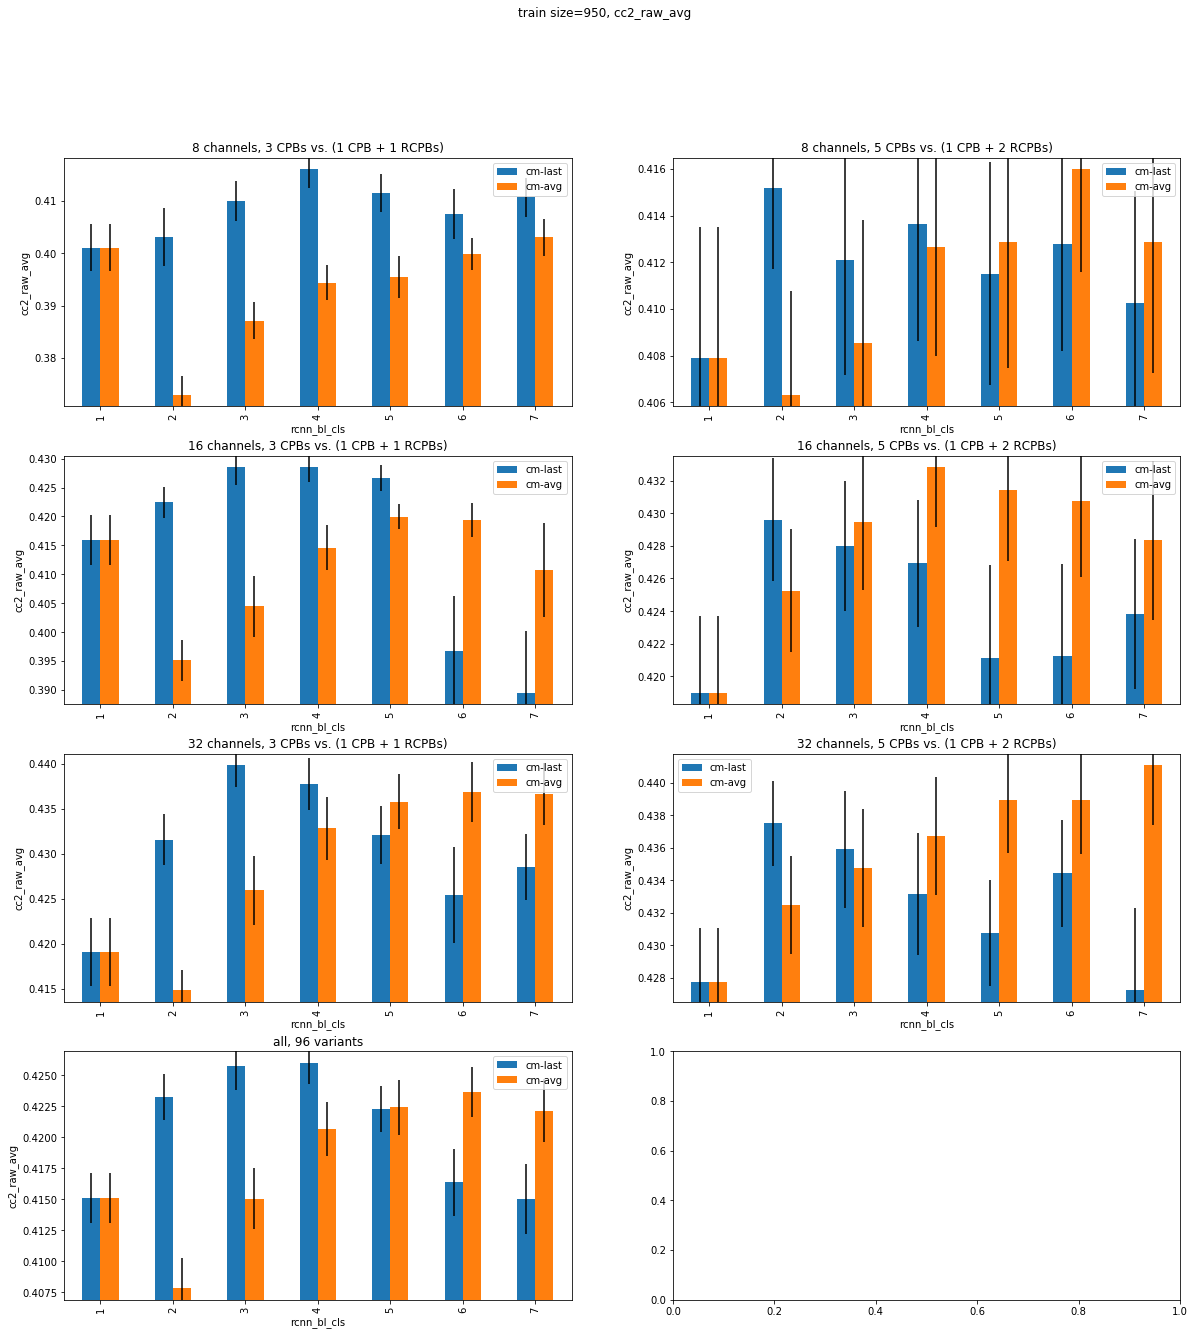

1900
(1584, 2)
seed=0, mean 0.4486388491705699 std 0.02667647830102246
seed=1, mean 0.44736882233967123 std 0.0263692168103667
corr 0.8627853443281939
(792, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          16           1              0.001311
                                poisson    3          16           1              0.006747
          True                  mse        3          16           1              0.003271
                                poisson    3          16           1              0.000000
softplus  False                 mse        3          16           1              0.000000
                                poisson    3          16           1              0.002219
          True                  mse        3          16           1              0.001768
                                poisson    3          16           1              0.000247
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          16           1              0.0
             

,cm-last,cm-avg
rcnn_bl_cls,,
1,7034.0,7034.0
2,7034.0,7034.0
3,7050.0,7050.0
4,7066.0,7066.0
5,7082.0,7082.0
6,7098.0,7098.0
7,7114.0,7114.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.227%,0.227%
4,0.455%,0.455%
5,0.682%,0.682%
6,0.910%,0.910%
7,1.137%,1.137%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.440623,0.440623
2,0.441471,0.415958
3,0.443757,0.426701
4,0.442725,0.431085
5,0.439511,0.433218
6,0.438570,0.433450
7,0.438776,0.433919


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.192%,-5.598%
3,0.711%,-3.160%
4,0.477%,-2.165%
5,-0.252%,-1.681%
6,-0.466%,-1.628%
7,-0.419%,-1.522%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,8218.0,8218.0
2,8218.0,8218.0
3,8250.0,8250.0
4,8282.0,8282.0
5,8314.0,8314.0
6,8346.0,8346.0
7,8378.0,8378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.389%,0.389%
4,0.779%,0.779%
5,1.168%,1.168%
6,1.558%,1.558%
7,1.947%,1.947%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.445299,0.445299
2,0.448194,0.446996
3,0.448801,0.447305
4,0.448079,0.450378
5,0.447033,0.450064
6,0.447158,0.448755
7,0.445958,0.451299


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.650%,0.381%
3,0.786%,0.451%
4,0.624%,1.141%
5,0.390%,1.070%
6,0.417%,0.776%
7,0.148%,1.347%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,11302.0,11302.0
2,11302.0,11302.0
3,11334.0,11334.0
4,11366.0,11366.0
5,11398.0,11398.0
6,11430.0,11430.0
7,11462.0,11462.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.283%,0.283%
4,0.566%,0.566%
5,0.849%,0.849%
6,1.133%,1.133%
7,1.416%,1.416%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.454544,0.454544
2,0.456808,0.436500
3,0.460679,0.449135
4,0.458801,0.453121
5,0.455336,0.456534
6,0.452803,0.457614
7,0.452183,0.456516


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.498%,-3.970%
3,1.350%,-1.190%
4,0.937%,-0.313%
5,0.174%,0.438%
6,-0.383%,0.675%
7,-0.519%,0.434%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,15974.0,15974.0
2,15974.0,15974.0
3,16038.0,16038.0
4,16102.0,16102.0
5,16166.0,16166.0
6,16230.0,16230.0
7,16294.0,16294.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.401%,0.401%
4,0.801%,0.801%
5,1.202%,1.202%
6,1.603%,1.603%
7,2.003%,2.003%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.454640,0.454640
2,0.462270,0.461841
3,0.462131,0.463633
4,0.461880,0.465415
5,0.462743,0.464897
6,0.461813,0.466797
7,0.463248,0.469283


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.678%,1.584%
3,1.648%,1.978%
4,1.592%,2.370%
5,1.782%,2.256%
6,1.578%,2.674%
7,1.893%,3.221%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,26750.0,26750.0
2,26750.0,26750.0
3,26814.0,26814.0
4,26878.0,26878.0
5,26942.0,26942.0
6,27006.0,27006.0
7,27070.0,27070.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.239%,0.239%
4,0.479%,0.479%
5,0.718%,0.718%
6,0.957%,0.957%
7,1.196%,1.196%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.458710,0.458710
2,0.459559,0.443937
3,0.466743,0.456926
4,0.465417,0.464000
5,0.465421,0.467300
6,0.464500,0.469209
7,0.463807,0.471724


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.185%,-3.221%
3,1.751%,-0.389%
4,1.462%,1.153%
5,1.463%,1.873%
6,1.262%,2.289%
7,1.111%,2.837%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,45310.0,45310.0
2,45310.0,45310.0
3,45438.0,45438.0
4,45566.0,45566.0
5,45694.0,45694.0
6,45822.0,45822.0
7,45950.0,45950.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.282%,0.282%
4,0.565%,0.565%
5,0.847%,0.847%
6,1.130%,1.130%
7,1.412%,1.412%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.460831,0.460831
2,0.466176,0.465441
3,0.466881,0.470201
4,0.466258,0.470073
5,0.467976,0.472141
6,0.465917,0.472518
7,0.467373,0.474828


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.160%,1.000%
3,1.313%,2.033%
4,1.178%,2.006%
5,1.551%,2.454%
6,1.104%,2.536%
7,1.420%,3.037%


all, 96 variants


,cm-last,cm-avg
rcnn_bl_cls,,
1,19098.0,19098.0
2,19098.0,19098.0
3,19154.0,19154.0
4,19210.0,19210.0
5,19266.0,19266.0
6,19322.0,19322.0
7,19378.0,19378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.293%,0.293%
4,0.586%,0.586%
5,0.880%,0.880%
6,1.173%,1.173%
7,1.466%,1.466%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.452441,0.452441
2,0.455746,0.445112
3,0.458165,0.452317
4,0.457193,0.455679
5,0.456337,0.457359
6,0.455127,0.458057
7,0.455224,0.459595


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.730%,-1.620%
3,1.265%,-0.028%
4,1.050%,0.716%
5,0.861%,1.087%
6,0.594%,1.241%
7,0.615%,1.581%


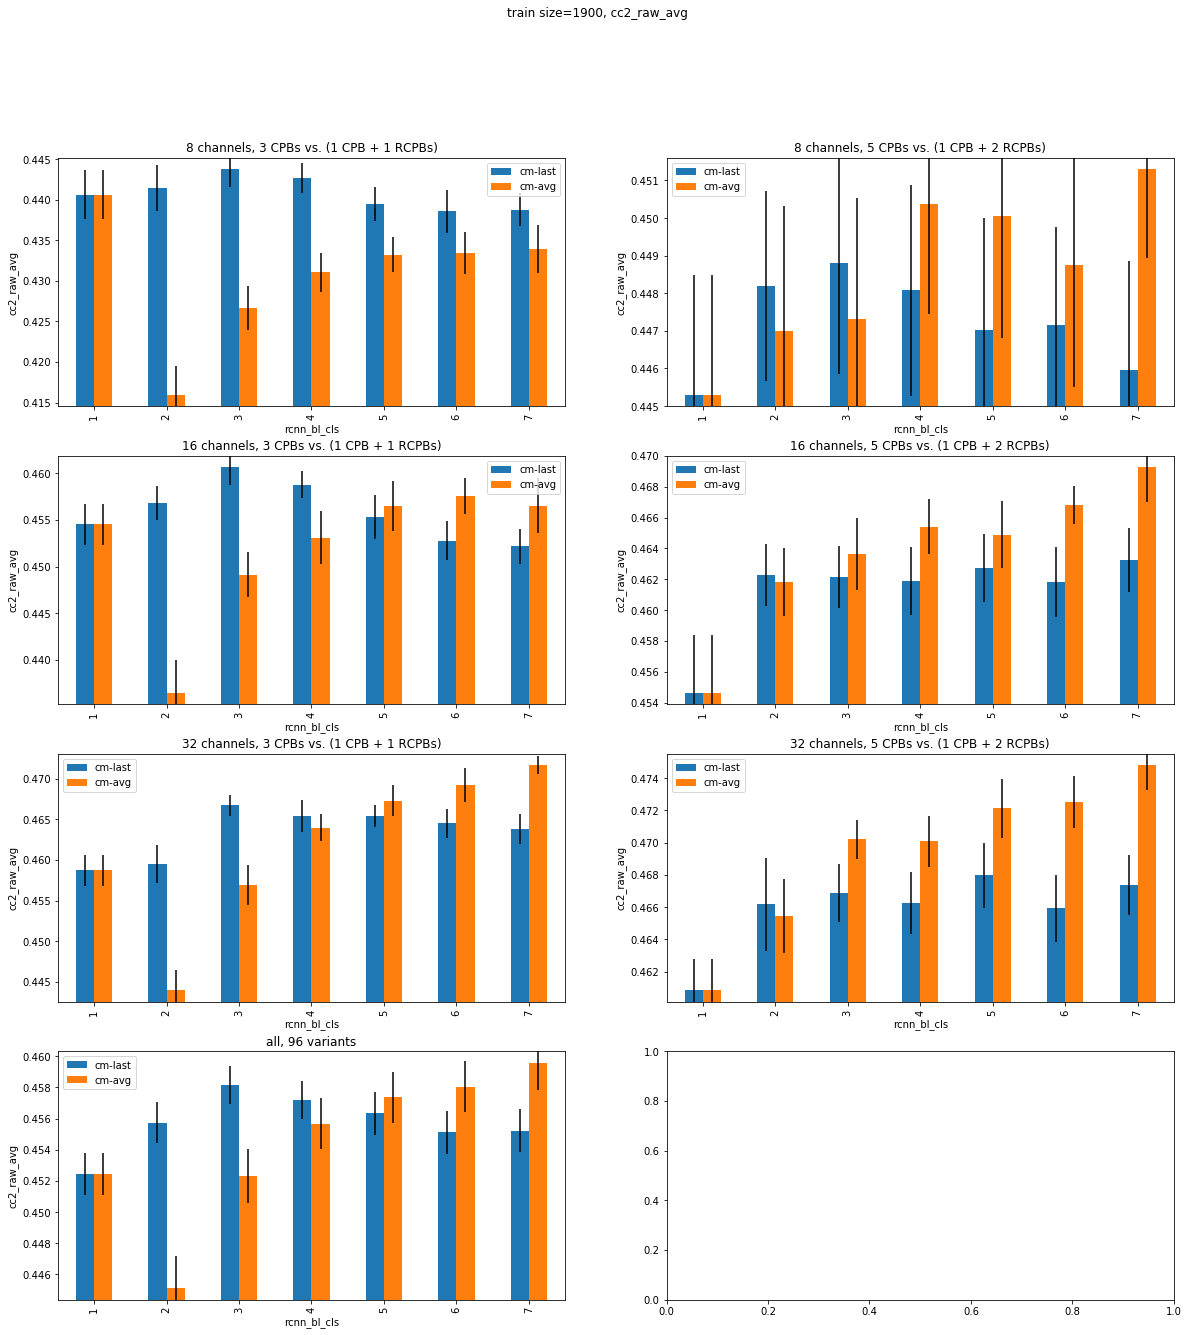

3800
(1584, 2)
seed=0, mean 0.47250367507642854 std 0.024234967862489472
seed=1, mean 0.4721472324971739 std 0.024355887879784797
corr 0.926140070534395
(792, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  ou

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        6          16           1              0.0
                                poisson    6          16           1              0.0
          True                  mse        6          16           1              0.0
                                poisson    6          16           1              0.0
softplus  False                 mse        6          16           1              0.0
                                poisson    6          16           1              0.0
          True                  mse        6          16           1              0.0
                                poisson    6          16           1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.000000
                                poisson    2    

,cm-last,cm-avg
rcnn_bl_cls,,
1,7034.0,7034.0
2,7034.0,7034.0
3,7050.0,7050.0
4,7066.0,7066.0
5,7082.0,7082.0
6,7098.0,7098.0
7,7114.0,7114.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.227%,0.227%
4,0.455%,0.455%
5,0.682%,0.682%
6,0.910%,0.910%
7,1.137%,1.137%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.462853,0.462853
2,0.459565,0.439730
3,0.464384,0.445076
4,0.458003,0.448882
5,0.455682,0.451966
6,0.455581,0.456264
7,0.452338,0.456587


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.710%,-4.996%
3,0.331%,-3.841%
4,-1.048%,-3.018%
5,-1.549%,-2.352%
6,-1.571%,-1.424%
7,-2.272%,-1.354%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,8218.0,8218.0
2,8218.0,8218.0
3,8250.0,8250.0
4,8282.0,8282.0
5,8314.0,8314.0
6,8346.0,8346.0
7,8378.0,8378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.389%,0.389%
4,0.779%,0.779%
5,1.168%,1.168%
6,1.558%,1.558%
7,1.947%,1.947%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.470734,0.470734
2,0.472194,0.468976
3,0.472441,0.473616
4,0.473102,0.472510
5,0.471512,0.472287
6,0.469968,0.477550
7,0.469534,0.477716


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.310%,-0.373%
3,0.363%,0.612%
4,0.503%,0.377%
5,0.165%,0.330%
6,-0.163%,1.448%
7,-0.255%,1.483%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,11302.0,11302.0
2,11302.0,11302.0
3,11334.0,11334.0
4,11366.0,11366.0
5,11398.0,11398.0
6,11430.0,11430.0
7,11462.0,11462.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.283%,0.283%
4,0.566%,0.566%
5,0.849%,0.849%
6,1.133%,1.133%
7,1.416%,1.416%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.475689,0.475689
2,0.476766,0.456885
3,0.477567,0.465693
4,0.480071,0.472844
5,0.480324,0.473132
6,0.475175,0.476678
7,0.474406,0.479585


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.227%,-3.953%
3,0.395%,-2.101%
4,0.921%,-0.598%
5,0.975%,-0.538%
6,-0.108%,0.208%
7,-0.270%,0.819%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,15974.0,15974.0
2,15974.0,15974.0
3,16038.0,16038.0
4,16102.0,16102.0
5,16166.0,16166.0
6,16230.0,16230.0
7,16294.0,16294.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.401%,0.401%
4,0.801%,0.801%
5,1.202%,1.202%
6,1.603%,1.603%
7,2.003%,2.003%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.486318,0.486318
2,0.486716,0.486353
3,0.487993,0.486830
4,0.489581,0.490812
5,0.489957,0.493192
6,0.490611,0.492031
7,0.488977,0.496468


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.082%,0.007%
3,0.344%,0.105%
4,0.671%,0.924%
5,0.748%,1.413%
6,0.883%,1.175%
7,0.547%,2.087%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,26750.0,26750.0
2,26750.0,26750.0
3,26814.0,26814.0
4,26878.0,26878.0
5,26942.0,26942.0
6,27006.0,27006.0
7,27070.0,27070.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.239%,0.239%
4,0.479%,0.479%
5,0.718%,0.718%
6,0.957%,0.957%
7,1.196%,1.196%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.482121,0.482121
2,0.480589,0.465923
3,0.488086,0.476404
4,0.489477,0.483212
5,0.486466,0.487493
6,0.489607,0.490249
7,0.493767,0.491562


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.318%,-3.360%
3,1.237%,-1.186%
4,1.526%,0.226%
5,0.901%,1.114%
6,1.553%,1.686%
7,2.416%,1.958%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,45310.0,45310.0
2,45310.0,45310.0
3,45438.0,45438.0
4,45566.0,45566.0
5,45694.0,45694.0
6,45822.0,45822.0
7,45950.0,45950.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.282%,0.282%
4,0.565%,0.565%
5,0.847%,0.847%
6,1.130%,1.130%
7,1.412%,1.412%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.490776,0.490776
2,0.490087,0.491964
3,0.494078,0.493323
4,0.496321,0.496249
5,0.495954,0.497035
6,0.497221,0.499424
7,0.505029,0.501567


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.140%,0.242%
3,0.673%,0.519%
4,1.130%,1.115%
5,1.055%,1.275%
6,1.313%,1.762%
7,2.904%,2.199%


all, 96 variants


,cm-last,cm-avg
rcnn_bl_cls,,
1,19098.0,19098.0
2,19098.0,19098.0
3,19154.0,19154.0
4,19210.0,19210.0
5,19266.0,19266.0
6,19322.0,19322.0
7,19378.0,19378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.293%,0.293%
4,0.586%,0.586%
5,0.880%,0.880%
6,1.173%,1.173%
7,1.466%,1.466%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.478082,0.478082
2,0.477653,0.468305
3,0.480758,0.473490
4,0.481092,0.477418
5,0.479983,0.479184
6,0.479694,0.482033
7,0.480675,0.483914


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.090%,-2.045%
3,0.560%,-0.960%
4,0.630%,-0.139%
5,0.398%,0.231%
6,0.337%,0.826%
7,0.542%,1.220%


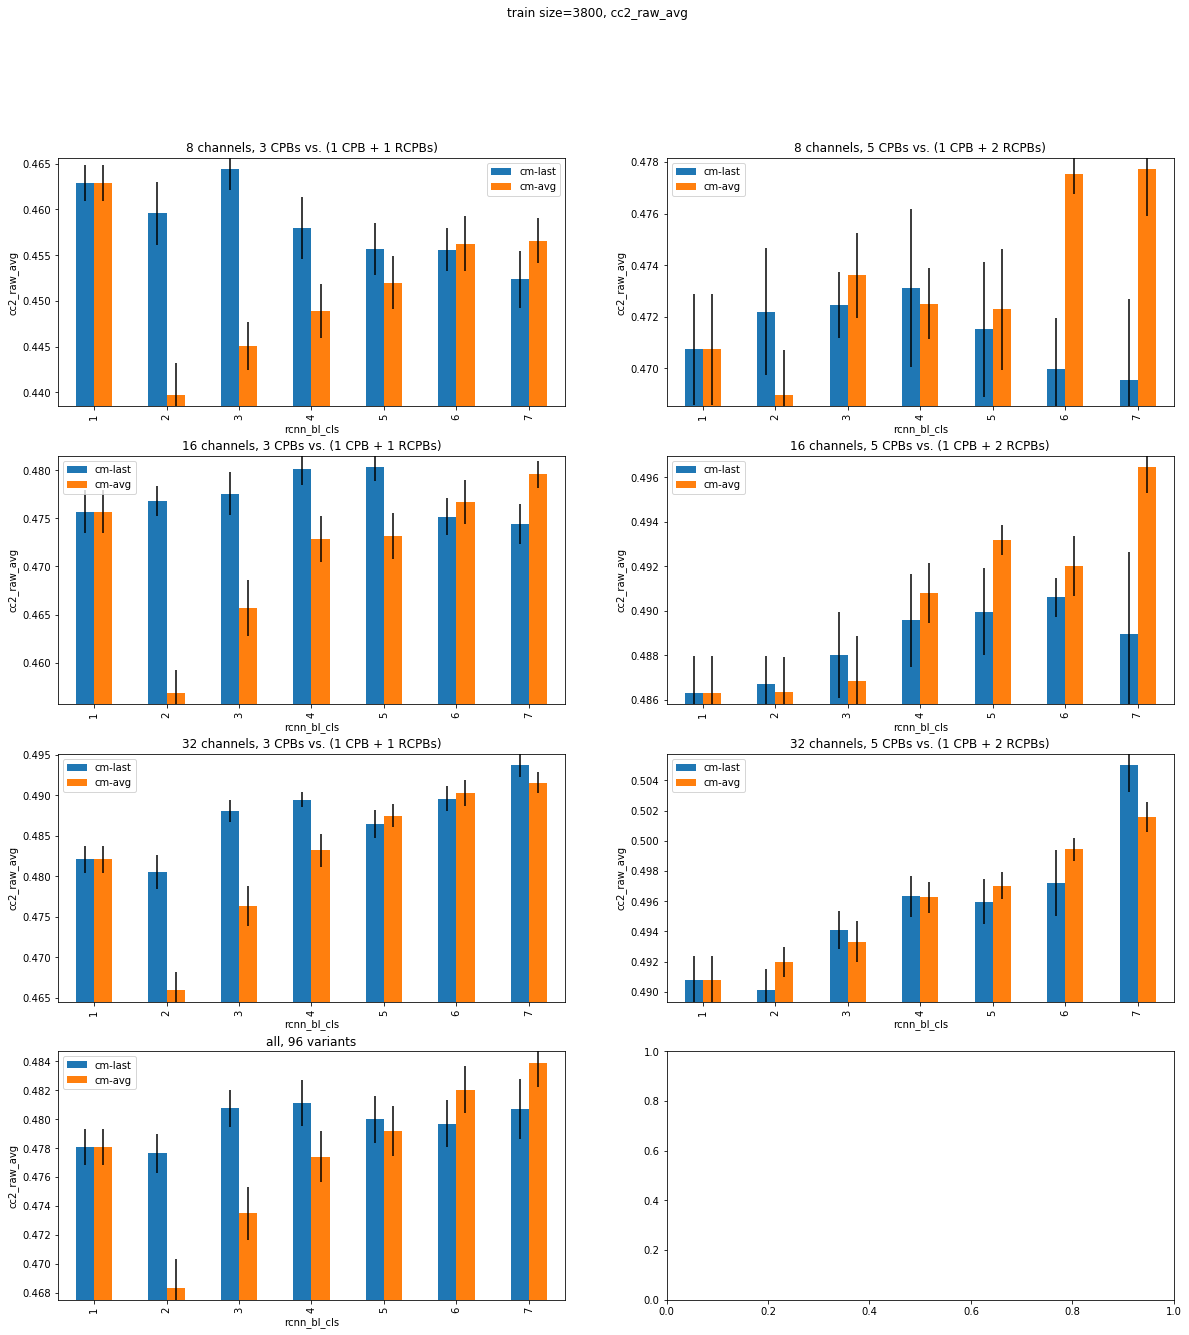

cc_raw_avg
950
(1584, 2)
seed=0, mean 0.6294790709925504 std 0.026000479165915434
seed=1, mean 0.6273740824270564 std 0.03131296367152059
corr 0.7717952905974392
(792, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        6          16           1              0.0
                                poisson    6          16           1              0.0
          True                  mse        6          16           1              0.0
                                poisson    6          16           1              0.0
softplus  False                 mse        6          16           1              0.0
                                poisson    6          16           1              0.0
          True                  mse        6          16           1              0.0
                                poisson    6          16           1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.001832
                                poisson    2    

,cm-last,cm-avg
rcnn_bl_cls,,
1,7034.0,7034.0
2,7034.0,7034.0
3,7050.0,7050.0
4,7066.0,7066.0
5,7082.0,7082.0
6,7098.0,7098.0
7,7114.0,7114.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.227%,0.227%
4,0.455%,0.455%
5,0.682%,0.682%
6,0.910%,0.910%
7,1.137%,1.137%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.619767,0.619767
2,0.621782,0.596973
3,0.627236,0.608766
4,0.632815,0.615158
5,0.629176,0.615587
6,0.625740,0.619146
7,0.628379,0.622140


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.325%,-3.678%
3,1.205%,-1.775%
4,2.105%,-0.744%
5,1.518%,-0.674%
6,0.964%,-0.100%
7,1.390%,0.383%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,8218.0,8218.0
2,8218.0,8218.0
3,8250.0,8250.0
4,8282.0,8282.0
5,8314.0,8314.0
6,8346.0,8346.0
7,8378.0,8378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.389%,0.389%
4,0.779%,0.779%
5,1.168%,1.168%
6,1.558%,1.558%
7,1.947%,1.947%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.625300,0.625300
2,0.631476,0.623926
3,0.629329,0.625891
4,0.630556,0.628868
5,0.628688,0.628972
6,0.630167,0.631807
7,0.627653,0.628846


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.988%,-0.220%
3,0.644%,0.094%
4,0.841%,0.571%
5,0.542%,0.587%
6,0.778%,1.041%
7,0.376%,0.567%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,11302.0,11302.0
2,11302.0,11302.0
3,11334.0,11334.0
4,11366.0,11366.0
5,11398.0,11398.0
6,11430.0,11430.0
7,11462.0,11462.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.283%,0.283%
4,0.566%,0.566%
5,0.849%,0.849%
6,1.133%,1.133%
7,1.416%,1.416%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.631658,0.631658
2,0.637369,0.615738
3,0.642869,0.623263
4,0.643038,0.631209
5,0.641593,0.635829
6,0.615134,0.635272
7,0.606770,0.626524


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.904%,-2.520%
3,1.775%,-1.329%
4,1.802%,-0.071%
5,1.573%,0.660%
6,-2.616%,0.572%
7,-3.940%,-0.813%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,15974.0,15974.0
2,15974.0,15974.0
3,16038.0,16038.0
4,16102.0,16102.0
5,16166.0,16166.0
6,16230.0,16230.0
7,16294.0,16294.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.401%,0.401%
4,0.801%,0.801%
5,1.202%,1.202%
6,1.603%,1.603%
7,2.003%,2.003%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.634792,0.634792
2,0.643222,0.639271
3,0.641995,0.642535
4,0.641132,0.645295
5,0.636258,0.644608
6,0.636628,0.644093
7,0.639059,0.642133


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.328%,0.705%
3,1.135%,1.220%
4,0.999%,1.654%
5,0.231%,1.546%
6,0.289%,1.465%
7,0.672%,1.156%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,26750.0,26750.0
2,26750.0,26750.0
3,26814.0,26814.0
4,26878.0,26878.0
5,26942.0,26942.0
6,27006.0,27006.0
7,27070.0,27070.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.239%,0.239%
4,0.479%,0.479%
5,0.718%,0.718%
6,0.957%,0.957%
7,1.196%,1.196%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.633799,0.633799
2,0.644660,0.631936
3,0.651551,0.640657
4,0.649941,0.645923
5,0.645420,0.648457
6,0.640159,0.648979
7,0.642734,0.648749


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.714%,-0.294%
3,2.801%,1.082%
4,2.547%,1.913%
5,1.834%,2.313%
6,1.003%,2.395%
7,1.410%,2.359%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,45310.0,45310.0
2,45310.0,45310.0
3,45438.0,45438.0
4,45566.0,45566.0
5,45694.0,45694.0
6,45822.0,45822.0
7,45950.0,45950.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.282%,0.282%
4,0.565%,0.565%
5,0.847%,0.847%
6,1.130%,1.130%
7,1.412%,1.412%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.641844,0.641844
2,0.649003,0.645052
3,0.647832,0.646641
4,0.646011,0.648348
5,0.643770,0.650223
6,0.646919,0.650314
7,0.641048,0.652068


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.115%,0.500%
3,0.933%,0.747%
4,0.649%,1.013%
5,0.300%,1.306%
6,0.791%,1.320%
7,-0.124%,1.593%


all, 96 variants


,cm-last,cm-avg
rcnn_bl_cls,,
1,19098.0,19098.0
2,19098.0,19098.0
3,19154.0,19154.0
4,19210.0,19210.0
5,19266.0,19266.0
6,19322.0,19322.0
7,19378.0,19378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.293%,0.293%
4,0.586%,0.586%
5,0.880%,0.880%
6,1.173%,1.173%
7,1.466%,1.466%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.631193,0.631193
2,0.637919,0.625482
3,0.640135,0.631292
4,0.640582,0.635800
5,0.637484,0.637279
6,0.632458,0.638268
7,0.630941,0.636743


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,1.065%,-0.905%
3,1.417%,0.016%
4,1.487%,0.730%
5,0.997%,0.964%
6,0.200%,1.121%
7,-0.040%,0.879%


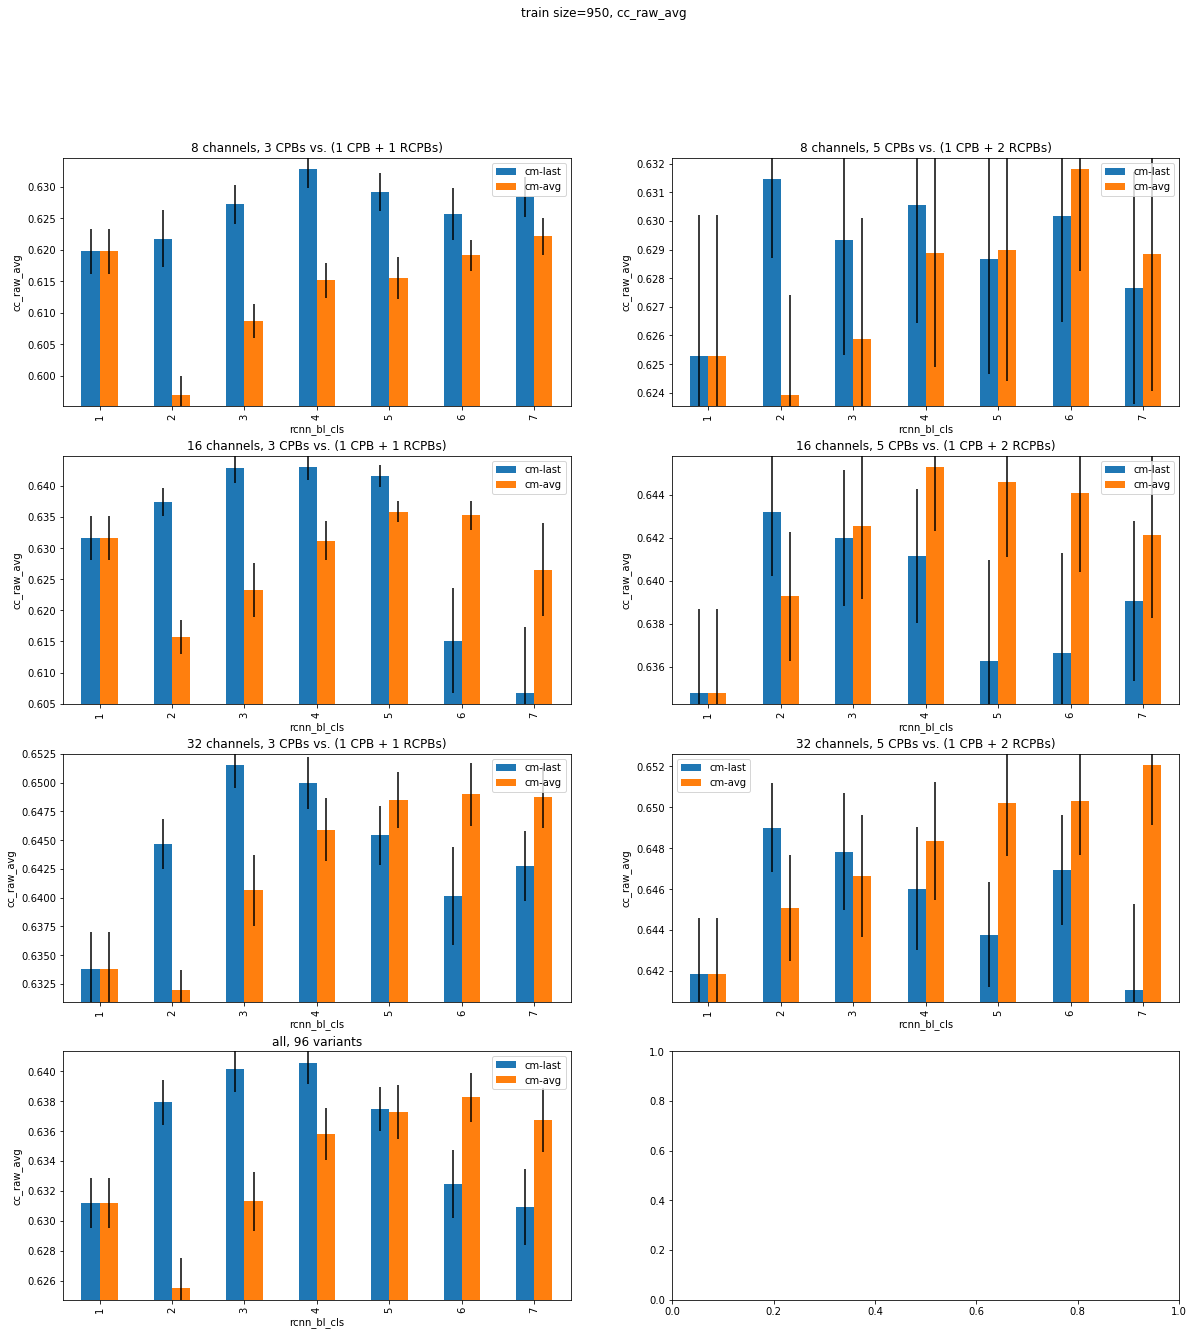

1900
(1584, 2)
seed=0, mean 0.6584638053815444 std 0.021054953207503495
seed=1, mean 0.6573882778966635 std 0.020712551009323364
corr 0.8415859611186779
(792, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  ou

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.000000
                                poisson    2          32           1              0.000482
          True                  mse        2          32           1              0.000287
                                poisson    2          32           1              0.000129
softplus  False                 mse        2          32           1              0.013271
                                poisson    2          32           1              0.000455
          True                  mse        2          32           1              0.007990
                                poisson    2          32           1              0.004092
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.000153
        

,cm-last,cm-avg
rcnn_bl_cls,,
1,7034.0,7034.0
2,7034.0,7034.0
3,7050.0,7050.0
4,7066.0,7066.0
5,7082.0,7082.0
6,7098.0,7098.0
7,7114.0,7114.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.227%,0.227%
4,0.455%,0.455%
5,0.682%,0.682%
6,0.910%,0.910%
7,1.137%,1.137%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.651824,0.651824
2,0.652847,0.633700
3,0.655129,0.641554
4,0.654634,0.644730
5,0.652012,0.646300
6,0.651352,0.646753
7,0.651646,0.647164


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.157%,-2.781%
3,0.507%,-1.576%
4,0.431%,-1.088%
5,0.029%,-0.848%
6,-0.072%,-0.778%
7,-0.027%,-0.715%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,8218.0,8218.0
2,8218.0,8218.0
3,8250.0,8250.0
4,8282.0,8282.0
5,8314.0,8314.0
6,8346.0,8346.0
7,8378.0,8378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.389%,0.389%
4,0.779%,0.779%
5,1.168%,1.168%
6,1.558%,1.558%
7,1.947%,1.947%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.656156,0.656156
2,0.658623,0.656814
3,0.659185,0.657376
4,0.658678,0.659728
5,0.657882,0.659719
6,0.658060,0.658626
7,0.656878,0.660617


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.376%,0.100%
3,0.462%,0.186%
4,0.384%,0.544%
5,0.263%,0.543%
6,0.290%,0.377%
7,0.110%,0.680%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,11302.0,11302.0
2,11302.0,11302.0
3,11334.0,11334.0
4,11366.0,11366.0
5,11398.0,11398.0
6,11430.0,11430.0
7,11462.0,11462.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.283%,0.283%
4,0.566%,0.566%
5,0.849%,0.849%
6,1.133%,1.133%
7,1.416%,1.416%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.662082,0.662082
2,0.664537,0.649627
3,0.667991,0.659281
4,0.666645,0.662225
5,0.664084,0.664483
6,0.662511,0.665678
7,0.661802,0.664766


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.371%,-1.881%
3,0.893%,-0.423%
4,0.689%,0.022%
5,0.302%,0.363%
6,0.065%,0.543%
7,-0.042%,0.406%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,15974.0,15974.0
2,15974.0,15974.0
3,16038.0,16038.0
4,16102.0,16102.0
5,16166.0,16166.0
6,16230.0,16230.0
7,16294.0,16294.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.401%,0.401%
4,0.801%,0.801%
5,1.202%,1.202%
6,1.603%,1.603%
7,2.003%,2.003%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.663562,0.663562
2,0.668867,0.667974
3,0.668824,0.669213
4,0.669099,0.670536
5,0.669669,0.670406
6,0.669153,0.672031
7,0.670194,0.674219


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.800%,0.665%
3,0.793%,0.852%
4,0.834%,1.051%
5,0.920%,1.031%
6,0.843%,1.276%
7,0.999%,1.606%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,26750.0,26750.0
2,26750.0,26750.0
3,26814.0,26814.0
4,26878.0,26878.0
5,26942.0,26942.0
6,27006.0,27006.0
7,27070.0,27070.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.239%,0.239%
4,0.479%,0.479%
5,0.718%,0.718%
6,0.957%,0.957%
7,1.196%,1.196%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.665415,0.665415
2,0.666526,0.655180
3,0.672406,0.665179
4,0.671263,0.670449
5,0.671757,0.672930
6,0.670921,0.674185
7,0.670496,0.676216


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.167%,-1.538%
3,1.051%,-0.035%
4,0.879%,0.756%
5,0.953%,1.129%
6,0.827%,1.318%
7,0.764%,1.623%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,45310.0,45310.0
2,45310.0,45310.0
3,45438.0,45438.0
4,45566.0,45566.0
5,45694.0,45694.0
6,45822.0,45822.0
7,45950.0,45950.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.282%,0.282%
4,0.565%,0.565%
5,0.847%,0.847%
6,1.130%,1.130%
7,1.412%,1.412%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.667654,0.667654
2,0.671515,0.670689
3,0.671882,0.674396
4,0.671954,0.674333
5,0.673593,0.676028
6,0.671716,0.676285
7,0.672991,0.678086


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.578%,0.455%
3,0.633%,1.010%
4,0.644%,1.000%
5,0.890%,1.254%
6,0.608%,1.293%
7,0.799%,1.563%


all, 96 variants


,cm-last,cm-avg
rcnn_bl_cls,,
1,19098.0,19098.0
2,19098.0,19098.0
3,19154.0,19154.0
4,19210.0,19210.0
5,19266.0,19266.0
6,19322.0,19322.0
7,19378.0,19378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.293%,0.293%
4,0.586%,0.586%
5,0.880%,0.880%
6,1.173%,1.173%
7,1.466%,1.466%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.661116,0.661116
2,0.663819,0.655664
3,0.665903,0.661167
4,0.665379,0.663667
5,0.664833,0.664978
6,0.663952,0.665593
7,0.664001,0.666845


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.409%,-0.825%
3,0.724%,0.008%
4,0.645%,0.386%
5,0.562%,0.584%
6,0.429%,0.677%
7,0.436%,0.867%


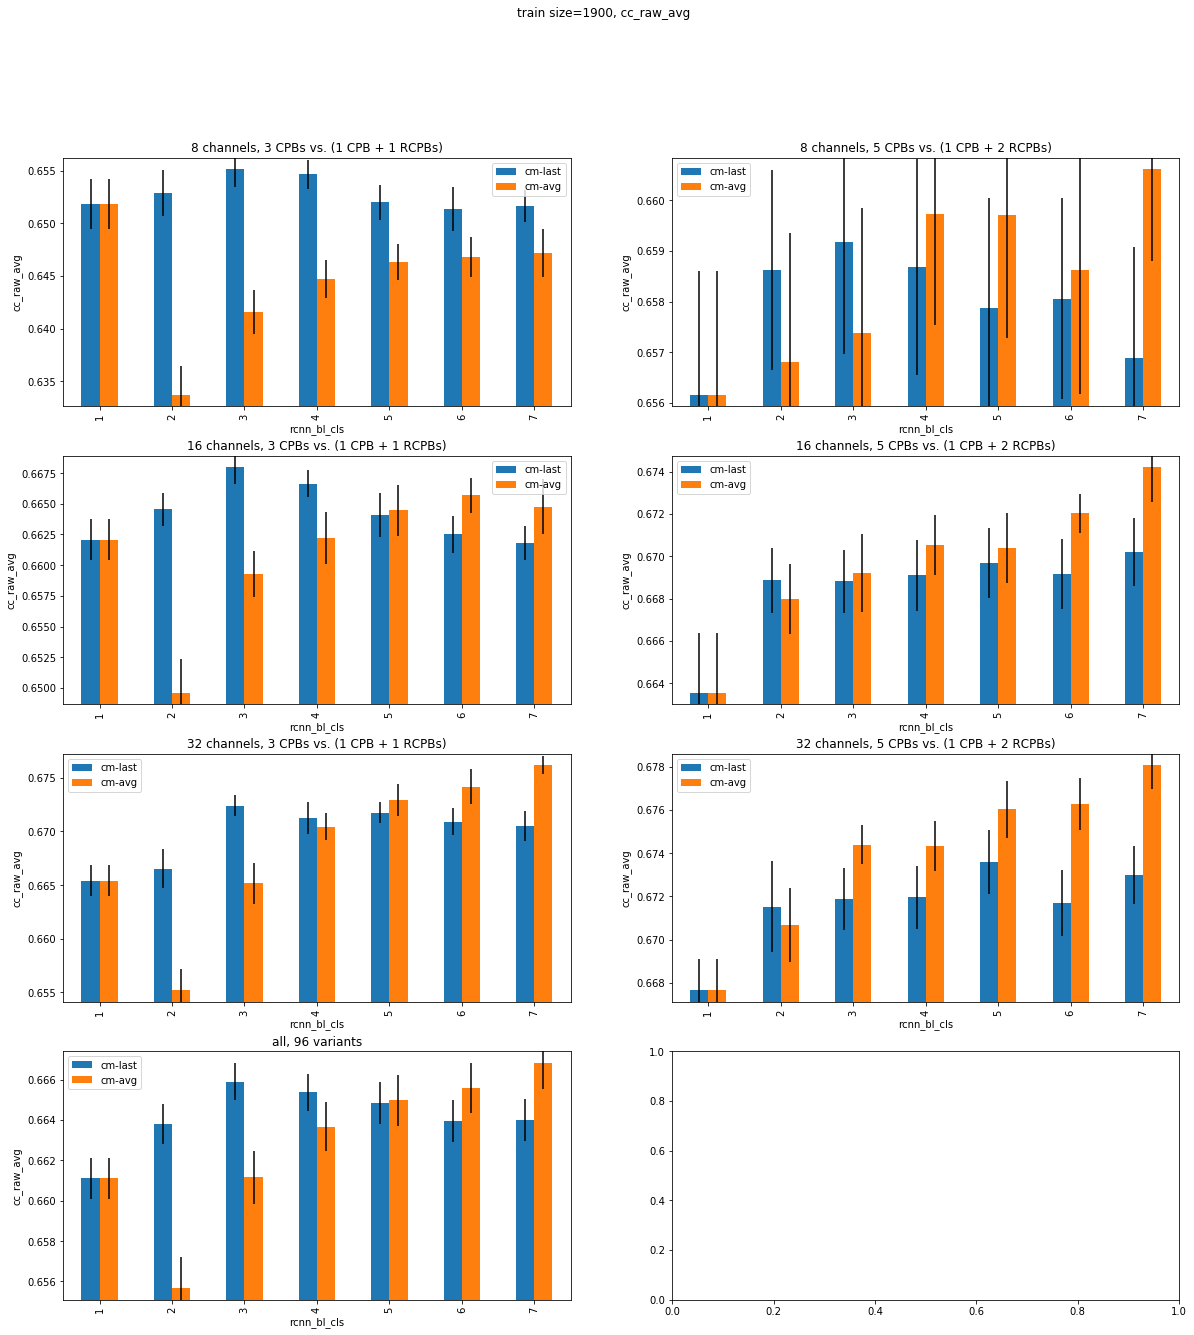

3800
(1584, 2)
seed=0, mean 0.677249898662462 std 0.01823084487664405
seed=1, mean 0.6770264133149865 std 0.01824215296771124
corr 0.9220147635263752
(792, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_c

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.000000
                                poisson    2          32           1              0.001992
          True                  mse        2          32           1              0.000705
                                poisson    2          32           1              0.001763
softplus  False                 mse        2          32           1              0.002530
                                poisson    2          32           1              0.000000
          True                  mse        2          32           1              0.002032
                                poisson    2          32           1              0.004926
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.002479
        

,cm-last,cm-avg
rcnn_bl_cls,,
1,7034.0,7034.0
2,7034.0,7034.0
3,7050.0,7050.0
4,7066.0,7066.0
5,7082.0,7082.0
6,7098.0,7098.0
7,7114.0,7114.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.227%,0.227%
4,0.455%,0.455%
5,0.682%,0.682%
6,0.910%,0.910%
7,1.137%,1.137%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.669972,0.669972
2,0.667779,0.652909
3,0.671309,0.656752
4,0.666566,0.659663
5,0.665089,0.661983
6,0.664920,0.665426
7,0.662592,0.665703


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.327%,-2.547%
3,0.200%,-1.973%
4,-0.508%,-1.539%
5,-0.729%,-1.192%
6,-0.754%,-0.679%
7,-1.102%,-0.637%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,8218.0,8218.0
2,8218.0,8218.0
3,8250.0,8250.0
4,8282.0,8282.0
5,8314.0,8314.0
6,8346.0,8346.0
7,8378.0,8378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.389%,0.389%
4,0.779%,0.779%
5,1.168%,1.168%
6,1.558%,1.558%
7,1.947%,1.947%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.676197,0.676197
2,0.677242,0.674457
3,0.677196,0.677962
4,0.678185,0.677033
5,0.677031,0.677123
6,0.675657,0.681166
7,0.675272,0.681204


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.155%,-0.257%
3,0.148%,0.261%
4,0.294%,0.124%
5,0.123%,0.137%
6,-0.080%,0.735%
7,-0.137%,0.740%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,11302.0,11302.0
2,11302.0,11302.0
3,11334.0,11334.0
4,11366.0,11366.0
5,11398.0,11398.0
6,11430.0,11430.0
7,11462.0,11462.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.283%,0.283%
4,0.566%,0.566%
5,0.849%,0.849%
6,1.133%,1.133%
7,1.416%,1.416%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.679251,0.679251
2,0.680371,0.665733
3,0.680992,0.672355
4,0.682984,0.677692
5,0.683213,0.677871
6,0.679737,0.680697
7,0.679251,0.682646


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.165%,-1.990%
3,0.256%,-1.015%
4,0.550%,-0.229%
5,0.583%,-0.203%
6,0.072%,0.213%
7,0.000%,0.500%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,15974.0,15974.0
2,15974.0,15974.0
3,16038.0,16038.0
4,16102.0,16102.0
5,16166.0,16166.0
6,16230.0,16230.0
7,16294.0,16294.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.401%,0.401%
4,0.801%,0.801%
5,1.202%,1.202%
6,1.603%,1.603%
7,2.003%,2.003%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.688109,0.688109
2,0.687883,0.687214
3,0.689067,0.687550
4,0.690261,0.690885
5,0.690555,0.692475
6,0.691151,0.691628
7,0.690282,0.695038


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.033%,-0.130%
3,0.139%,-0.081%
4,0.313%,0.403%
5,0.355%,0.634%
6,0.442%,0.511%
7,0.316%,1.007%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,26750.0,26750.0
2,26750.0,26750.0
3,26814.0,26814.0
4,26878.0,26878.0
5,26942.0,26942.0
6,27006.0,27006.0
7,27070.0,27070.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.239%,0.239%
4,0.479%,0.479%
5,0.718%,0.718%
6,0.957%,0.957%
7,1.196%,1.196%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.683931,0.683931
2,0.682985,0.672720
3,0.688632,0.680231
4,0.689847,0.685279
5,0.687833,0.688375
6,0.690218,0.690398
7,0.693432,0.691463


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.138%,-1.639%
3,0.687%,-0.541%
4,0.865%,0.197%
5,0.571%,0.650%
6,0.919%,0.946%
7,1.389%,1.101%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,cm-last,cm-avg
rcnn_bl_cls,,
1,45310.0,45310.0
2,45310.0,45310.0
3,45438.0,45438.0
4,45566.0,45566.0
5,45694.0,45694.0
6,45822.0,45822.0
7,45950.0,45950.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.282%,0.282%
4,0.565%,0.565%
5,0.847%,0.847%
6,1.130%,1.130%
7,1.412%,1.412%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.690893,0.690893
2,0.690160,0.691226
3,0.693263,0.692310
4,0.695114,0.694557
5,0.695017,0.695284
6,0.696005,0.697062
7,0.701673,0.698595


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.106%,0.048%
3,0.343%,0.205%
4,0.611%,0.530%
5,0.597%,0.635%
6,0.740%,0.893%
7,1.560%,1.115%


all, 96 variants


,cm-last,cm-avg
rcnn_bl_cls,,
1,19098.0,19098.0
2,19098.0,19098.0
3,19154.0,19154.0
4,19210.0,19210.0
5,19266.0,19266.0
6,19322.0,19322.0
7,19378.0,19378.0


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,0.000%,0.000%
3,0.293%,0.293%
4,0.586%,0.586%
5,0.880%,0.880%
6,1.173%,1.173%
7,1.466%,1.466%


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.681392,0.681392
2,0.681070,0.674043
3,0.683410,0.677860
4,0.683826,0.680852
5,0.683123,0.682185
6,0.682948,0.684396
7,0.683750,0.685775


,cm-last,cm-avg
rcnn_bl_cls,,
1,0.000%,0.000%
2,-0.047%,-1.079%
3,0.296%,-0.518%
4,0.357%,-0.079%
5,0.254%,0.116%
6,0.228%,0.441%
7,0.346%,0.643%


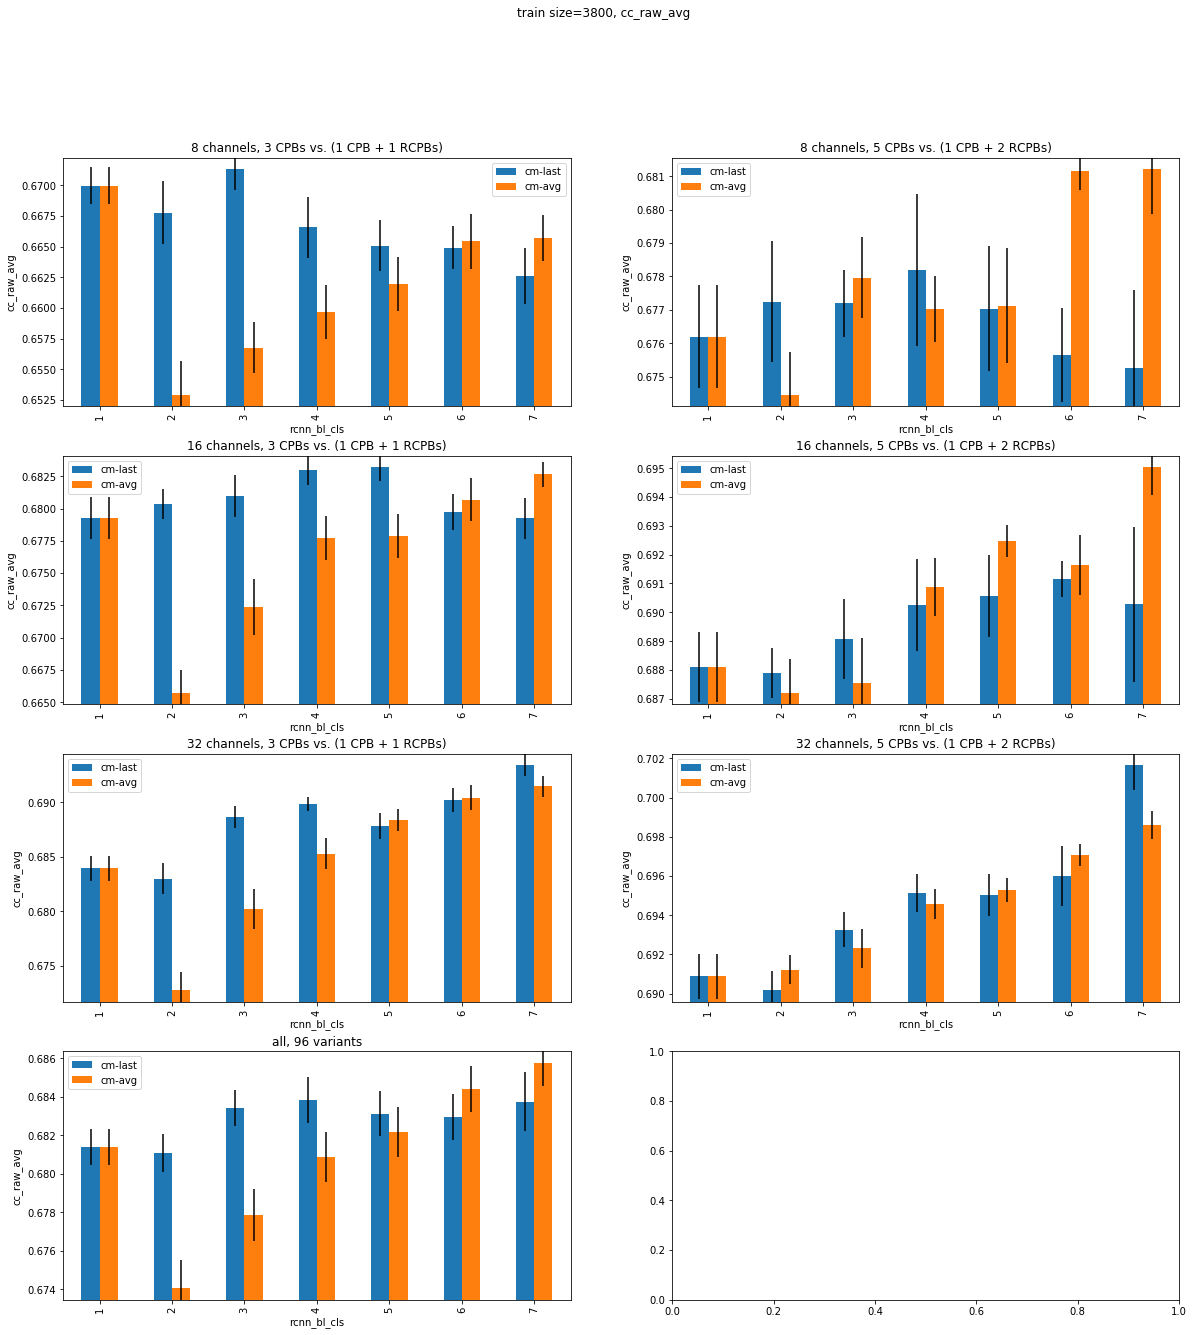

In [9]:
main_loop(df_main_result)